copied from [base_train.py](https://github.com/karpathy/nanochat/blob/master/scripts/base_train.py)

The base_train script pulls lots of stuff together much of which I haven't "copied" yet. There are lots of settings, periodic collection of metrics, code to handle distributed training, logging to wandb, etc. Eventually we'll want to do all that. My goal in this notebook, though, is to bring in just enough to run a training loop locally on my macbook CPU.

In [1]:
import sys
sys.path.append('../my_nanochat')
from my_nanochat.my_gpt import GPTConfig, GPT
import my_nanochat.my_tokenizer
from my_nanochat.my_dataloader import tokenizing_distributed_data_loader
import torch
import matplotlib.pyplot as plt
import math

In [2]:
device = "cpu"

# model architecture
depth = 4
max_seq_len = 128

# training horizon
num_iterations = 1_000

# optimization (not sure why this section is called that yet)
device_batch_size = 1
total_batch_size = 128 # (device_batch_size x max_seq_len)

# these next 4 are for the optimizers and we already saw them in setup_optimizers()
embedding_lr = 0.2
unembedding_lr = 0.004
weight_decay = 0.0
matrix_lr = 0.02

grad_clip = 1.0

# these 3 look like they control something we haven't seen yet, some type of LR adjuster
warmup_ratio = 0.0
warmdown_ratio = 0.2
final_lr_fraction = 0.0

In [3]:
tokenizer = my_nanochat.my_tokenizer.get_tokenizer()
vocab_size = tokenizer.get_vocab_size()
vocab_size

65537

In [4]:
# model kwargs are derived from desired depth of model
num_layers = depth
model_dim = depth * 64 # so for example in the default in GPTConfig it's 12 * 64 = 768)
num_heads = max(1, (model_dim + 127) // 128)
num_kv_heads = num_heads
num_layers, model_dim, num_heads, num_kv_heads

(4, 256, 2, 2)

In [5]:
# figure out the needed gradient accumulation to reach the desired total batch size
tokens_per_fwdbwd = device_batch_size * max_seq_len
grad_accum_steps = total_batch_size // tokens_per_fwdbwd
tokens_per_fwdbwd, grad_accum_steps

(128, 1)

In [6]:
# should I make total_batch_size bigger to see how we use multiple micro-batches?

In [7]:
model_config_kwargs = dict(
    sequence_len=max_seq_len,
    vocab_size=vocab_size, 
    n_layer=num_layers,
    n_head=num_heads,
    n_kv_head=num_kv_heads,
    n_embd=model_dim,
)
model_config = GPTConfig(**model_config_kwargs)
model = GPT(model_config)

In [8]:
model

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(65537, 256)
    (h): ModuleList(
      (0-3): 4 x Block(
        (attn): CausalSelfAttention(
          (c_q): Linear(in_features=256, out_features=256, bias=False)
          (c_k): Linear(in_features=256, out_features=256, bias=False)
          (c_v): Linear(in_features=256, out_features=256, bias=False)
          (c_proj): Linear(in_features=256, out_features=256, bias=False)
        )
        (mlp): MLP(
          (c_fc): Linear(in_features=256, out_features=1024, bias=False)
          (c_proj): Linear(in_features=1024, out_features=256, bias=False)
        )
      )
    )
  )
  (lm_head): Linear(in_features=256, out_features=65537, bias=False)
)

In [9]:
model.init_weights()

In [10]:
orig_model = model # original, uncompiled model -- looks like even in this minimal notebook we might use it

In [11]:
model = torch.compile(model, dynamic=False)
model

OptimizedModule(
  (_orig_mod): GPT(
    (transformer): ModuleDict(
      (wte): Embedding(65537, 256)
      (h): ModuleList(
        (0-3): 4 x Block(
          (attn): CausalSelfAttention(
            (c_q): Linear(in_features=256, out_features=256, bias=False)
            (c_k): Linear(in_features=256, out_features=256, bias=False)
            (c_v): Linear(in_features=256, out_features=256, bias=False)
            (c_proj): Linear(in_features=256, out_features=256, bias=False)
          )
          (mlp): MLP(
            (c_fc): Linear(in_features=256, out_features=1024, bias=False)
            (c_proj): Linear(in_features=1024, out_features=256, bias=False)
          )
        )
      )
    )
    (lm_head): Linear(in_features=256, out_features=65537, bias=False)
  )
)

In [12]:
num_params = sum([param.numel() for param in model.parameters()])
num_params

36700672

In [13]:
total_tokens = total_batch_size * num_iterations
total_tokens # total number of training tokens

128000

In [14]:
# initialize optimizer
optimizers = model.setup_optimizers(
    unembedding_lr=unembedding_lr,
    embedding_lr=embedding_lr,
    matrix_lr=matrix_lr,
    weight_decay=weight_decay,
)
adamw_optimizer, muon_optimizer = optimizers

Scaling the LR for the AdamW parameters proportional to 1/sqrt(256/768) = 1.7320508075688774


In [15]:
# initialize DataLoader
train_loader = tokenizing_distributed_data_loader(device_batch_size, max_seq_len, split="train", device=device)
x, y = next(train_loader)
x.shape, y.shape

(torch.Size([1, 128]), torch.Size([1, 128]))

In [16]:
# set up hyperparameter scheulders

In [17]:
# learning rate scheduler
def get_lr_multiplier(it):
    warmup_iters = round(warmup_ratio * num_iterations)
    warmdown_iters = round(warmdown_ratio * num_iterations)
    if it < warmup_iters:
        return (it + 1) / warmup_iters
    elif it <= num_iterations - warmdown_iters:
        return 1.0
    else:
        progress = (num_iterations - it) / warmdown_iters
        return progress * 1.0 + (1 - progress) * final_lr_fraction

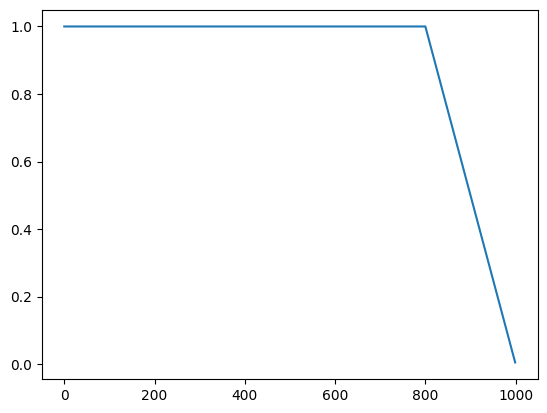

In [18]:
plt.plot([get_lr_multiplier(it) for it in range(num_iterations)]);

In [19]:
def get_muon_momentum(it):
    frac = min(it / 300, 1)
    momentum = (1 - frac) * 0.85  + frac * 0.95
    return momentum

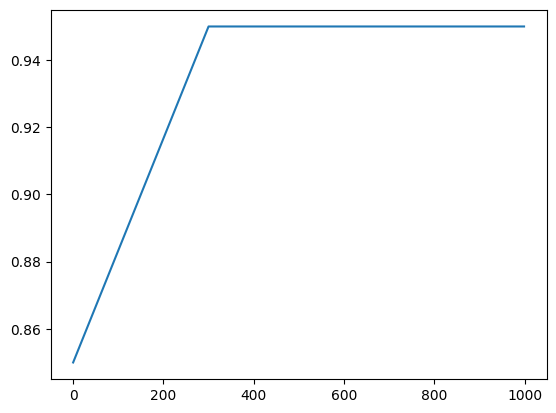

In [20]:
plt.plot([get_muon_momentum(it) for it in range(num_iterations)]);

### the training loop!

In [42]:
for step in range(num_iterations):
    for micro_step in range(grad_accum_steps):
        loss = model(x, y)
        train_loss = loss.detach()
        loss = loss / grad_accum_steps # seems import to understand, but n/a here since grad_accum_steps is 1, see his comment
        loss.backward()
        x, y = next(train_loader)
    # gradient clipping
    if grad_clip > 0.0:
        torch.nn.utils.clip_grad_norm_(orig_model.parameters(), grad_clip) # check exactly what this does, it's not a simple cip
    # step optimizers
    lrm = get_lr_multiplier(step)
    for opt in optimizers:
        for group in opt.param_groups:
            group["lr"] = group["initial_lr"] * lrm
    muon_momentum = get_muon_momentum(step)
    for group in muon_optimizer.param_groups:
        group["momentum"] = muon_momentum
    for opt in optimizers:
        opt.step()
    model.zero_grad(set_to_none=True)

    if step % 10 == 0:
        print(f"step: {step}, loss: {train_loss}")

step: 0, loss: 11.090365409851074
step: 10, loss: 7.7422566413879395
step: 20, loss: 7.608449935913086
step: 30, loss: 8.686348915100098
step: 40, loss: 6.493867874145508
step: 50, loss: 6.350435256958008
step: 60, loss: 8.222393035888672
step: 70, loss: 8.76060676574707
step: 80, loss: 8.194111824035645
step: 90, loss: 10.117965698242188
step: 100, loss: 6.094529151916504
step: 110, loss: 7.720015525817871
step: 120, loss: 8.661786079406738
step: 130, loss: 7.964576244354248
step: 140, loss: 6.710716247558594
step: 150, loss: 7.896536827087402
step: 160, loss: 4.46191930770874
step: 170, loss: 8.46756362915039
step: 180, loss: 7.578097343444824
step: 190, loss: 7.9622955322265625
step: 200, loss: 8.401297569274902
step: 210, loss: 8.066152572631836
step: 220, loss: 7.410600185394287
step: 230, loss: 7.702786922454834
step: 240, loss: 9.083930015563965
step: 250, loss: 7.626721382141113
step: 260, loss: 8.016225814819336
step: 270, loss: 8.307340621948242
step: 280, loss: 7.89013338088

In [43]:
torch.save(orig_model.state_dict(), "model.pth")

In [44]:
!ls -lh model.pth

-rw-r--r--  1 ericsilberstein  staff   140M Oct 31 06:52 model.pth


In [88]:
# show top 3 next tokens for a few prompts
for prompt in ['The person', 'He went to', '1 + 2 = ', 'first of', '3 cats and 2', 'mom and', 'the red', 'She']:
    logits = orig_model(torch.tensor([tokenizer.encode(prompt)])).detach()
    top_3_next_tokens = torch.topk(logits[0,-1,:], k=3).indices
    print(f"{prompt}{'|'.join([tokenizer.decode([token]) for token in top_3_next_tokens])}")

The person,|.| of
He went to the| be| a
1 + 2 = 19|16|17
first of the| a| 
3 cats and 20| to|,
mom and,|.| and
the red,|.| and
She the| a| 


It's not random, that's good. It looks like it's at least learned that tokens like "and" and "." are common and it's completing the "1 + 2" with numbers. It's probably not worth spending much time on this until I get the proper validation stuff copied over and can train on a GPU.